In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, cross_val_predict
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
import pyearth as Earth

In [8]:
#getting data and dropping unnecessary columns
data = pd.read_csv("test.csv") ###for some reason the normal csv didn't work for me, so i made an extra one that has the 22,000 num of observations
data = data.set_index('player_name')
data = data.drop(['Unnamed: 64', 'Unnamed: 0', 'Unnamed: 65', 'rimmade+rimmiss', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'num', 'type', 'pid'], axis=1)

#getting dummies of all variables
data_dummified = pd.get_dummies(data)

#splitting data 60/40 and stratifying
y = data_dummified.drafted
X = data_dummified.drop('drafted', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 45, stratify = y)

#for xgboost
train = pd.concat([X_train, y_train], axis=1)

class0 = train.loc[train['drafted'] == 0,:]
class1 = train.loc[train['drafted'] == 1,:]
spw = len(class0)/len(class1)


In [10]:
### All of our models

## best DT model
model_dt = BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state = 45),
                                 n_estimators = 250, 
                                 max_features = 0.3, 
                                 max_samples = 0.5,
                                 bootstrap = False, 
                                 bootstrap_features = True, 
                                 random_state = 45, 
                                 n_jobs = -1).fit(X_train, y_train)
## best AdaBoost Model
model_ada = AdaBoostClassifier(random_state = 45, 
                               base_estimator = DecisionTreeClassifier(max_depth = 8),
                               n_estimators = 10, 
                               learning_rate = 0.02).fit(X_train, y_train)

## best RF model
model_rf = RandomForestClassifier(random_state = 45, 
                                  bootstrap = False,
                                  n_estimators = 500,
                                  max_leaf_nodes = 500,
                                  max_depth = 20,
                                  n_jobs=-1).fit(X_train, y_train)

## best XGBoost model
model_xgb = xgb.XGBClassifier(objective = 'binary:logistic', 
                              random_state = 45, 
                              gamma = 0.1, 
                              learning_rate = 0.01,
                              max_depth = 6, 
                              n_estimators = 25,
                              reg_lambda = 0, 
                              scale_pos_weight = spw).fit(X_train, y_train)

In [19]:
##getting test classification accuracies of all models

test_accuracy_ada = model_ada.score(X_test, y_test)


test_accuracy_rf = model_rf.score(X_test, y_test) 

test_accuracy_dt = model_dt.score(X_test, y_test)

test_accuracy_xgb = model_xgb.score(X_test, y_test)


print("Adaboost accuracy = " + str((test_accuracy_ada)*100) + "%")
print("Random forest accuracy = " + str((test_accuracy_rf)*100) + "%")
print("Decision Tree accuracy = " + str((test_accuracy_dt)*100) + "%")
print("XGBoost accuracy = " + str((test_accuracy_xgb)*100) + "%")

Adaboost accuracy = 97.39595178530817%
Random forest accuracy = 98.07823516033659%
Decision Tree accuracy = 98.06686377075279%
XGBoost accuracy = 94.86013190811917%


In [ ]:
#### checking accuracies and recalls of different emsembles

In [23]:
#hard voting -- acc score on test data
hv_ensemble_model = VotingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('dt',model_dt),('xgb',model_xgb)])
hv_ensemble_model.fit(X_train,y_train)
hv_ensemble_model.score(X_test, y_test)*100

98.0896065499204

In [27]:
#idk how to get recall and stuff from this when voting is hard



In [ ]:
####################

In [28]:
#soft voting
sv_ensemble_model = VotingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('dt',model_dt),('xgb',model_xgb)],
                                 voting='soft')
sv_ensemble_model.fit(X_train,y_train)
sv_ensemble_model.score(X_test, y_test)*100

98.112349329088

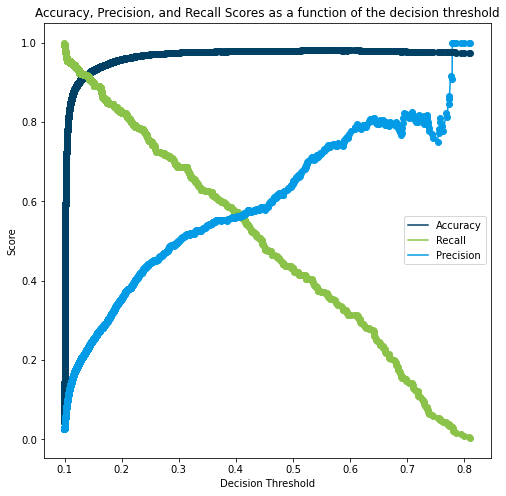

In [42]:
#finding the optimal threshold
cross_val_ypred = cross_val_predict(sv_ensemble_model, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys) 

#creating a df of thresholds, recall, precision, and accuracy
df_thr = pd.DataFrame({'thr': thresholds, 'recall': r[:-1], 'acc': accuracys, 'precision': p[:-1]})

#plotting a curve of recall, precision, and accuracy at all thresholds
def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, '#004065', label='Accuracy')
    plt.plot(thresholds, recalls[:-1], "#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "#039be5", label="Precision")
    plt.plot(thresholds, accuracys, 'o', color='#004065')
    plt.plot(thresholds, recalls[:-1], "o", color = '#8bc34a')
    plt.plot(thresholds, precisions[:-1], "o", color='#039be5')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [45]:
df_thr[(df_thr['recall'] > 0.916) & (df_thr['acc'] > 0.916)]

,thr,recall,acc,precision
10487,0.136697,0.918429,0.916066,0.219495
10488,0.136786,0.918429,0.916142,0.219653
10489,0.136809,0.918429,0.916218,0.219812
10490,0.136855,0.918429,0.916294,0.219971
10491,0.136873,0.918429,0.916370,0.220130
10492,0.136997,0.918429,0.916446,0.220290
10493,0.137051,0.918429,0.916521,0.220450
10494,0.137062,0.918429,0.916597,0.220610
10495,0.137065,0.918429,0.916673,0.220770
10496,0.137247,0.918429,0.916749,0.220930


Train Accuracy: 95.48%
Train Recall: 100.0%
Test Accuracy: 91.87%
Test Recall: 92.73%


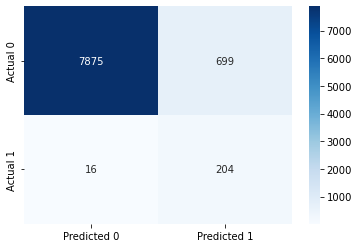

In [50]:
#choosing 0.138327  as I feel it was good balance between accuracy and recall
desired_threshold = 0.138327

#getting train accuracy and recall
ypred_prob_train = sv_ensemble_model.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

#getting test accuracy and recall
ypred_prob_test = sv_ensemble_model.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: " + str(round(accuracy_score(y_train, ypred_train)*100, 2)) + "%")
print("Train Recall: " + str(recall_score(y_train, ypred_train)*100) + "%")
print("Test Accuracy: " + str(round(accuracy_score(y_test, ypred_test)*100, 2)) + "%")
print("Test Recall: " + str(round(recall_score(y_test, ypred_test)*100, 2)) + "%")

#confusion matrix of test data
cm = pd.DataFrame(confusion_matrix(y_test, ypred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [53]:
####sv_ensemble_model.feature_importances_

AttributeError: 'VotingClassifier' object has no attribute 'feature_importances_'

In [ ]:
#############################################

In [41]:
###stacking classifier w log reg model as meta

stacking_ensemble_model = StackingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('dt',model_dt),('xgb',model_xgb)],
                                   final_estimator=LogisticRegression(random_state=1,max_iter=10000),n_jobs=-1,
                                   cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1))
stacking_ensemble_model.fit(X_train,y_train)
stacking_ensemble_model.score(X_test, y_test)*100

98.16920627700705

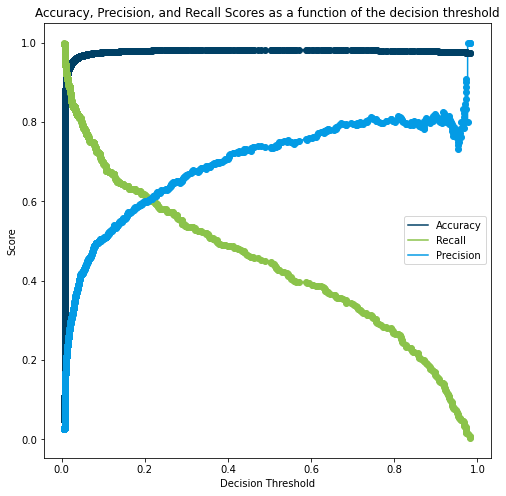

In [47]:
#finding the optimal threshold
cross_val_ypred = cross_val_predict(stacking_ensemble_model, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys) 

#creating a df of thresholds, recall, precision, and accuracy
df_thr = pd.DataFrame({'thr': thresholds, 'recall': r[:-1], 'acc': accuracys, 'precision': p[:-1]})

#plotting a curve of recall, precision, and accuracy at all thresholds
def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, '#004065', label='Accuracy')
    plt.plot(thresholds, recalls[:-1], "#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "#039be5", label="Precision")
    plt.plot(thresholds, accuracys, 'o', color='#004065')
    plt.plot(thresholds, recalls[:-1], "o", color = '#8bc34a')
    plt.plot(thresholds, precisions[:-1], "o", color='#039be5')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [48]:
df_thr[(df_thr['recall'] > 0.916) & (df_thr['acc'] > 0.916)]

,thr,recall,acc,precision
10518,0.012418,0.918429,0.916066,0.219495
10519,0.012426,0.918429,0.916142,0.219653
10520,0.012426,0.918429,0.916218,0.219812
10521,0.012433,0.918429,0.916294,0.219971
10522,0.012437,0.918429,0.916370,0.220130
10523,0.012437,0.918429,0.916446,0.220290
10524,0.012438,0.918429,0.916521,0.220450
10525,0.012454,0.918429,0.916597,0.220610
10526,0.012469,0.918429,0.916673,0.220770
10527,0.012469,0.918429,0.916749,0.220930


Train Accuracy: 95.45%
Train Recall: 100.0%
Test Accuracy: 92.09%
Test Recall: 92.27%


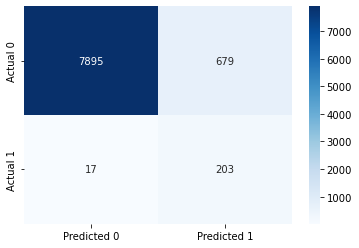

In [51]:
#choosing 0.012840 as I feel it was good balance between accuracy and recall
desired_threshold = 0.012840

#getting train accuracy and recall
ypred_prob_train = stacking_ensemble_model.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

#getting test accuracy and recall
ypred_prob_test = stacking_ensemble_model.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: " + str(round(accuracy_score(y_train, ypred_train)*100, 2)) + "%")
print("Train Recall: " + str(recall_score(y_train, ypred_train)*100) + "%")
print("Test Accuracy: " + str(round(accuracy_score(y_test, ypred_test)*100, 2)) + "%")
print("Test Recall: " + str(round(recall_score(y_test, ypred_test)*100, 2)) + "%")

#confusion matrix of test data
cm = pd.DataFrame(confusion_matrix(y_test, ypred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');